# Steam Hours Capestone

## Description
The gaming industry now makes more money than the film and music industry combined. We have decided to look into what makes a customer play games for large amounts of time. We will look into what features if any contribute to the number of gameplay hours and create a machine learning model to estimate the hours played for certain types of games. With the model we will be able to predict the value of a game.

## Goal
* Discover drivers of hours played from database
* Use drivers to develop a machine learning model to determine value of the product
* This information could be used to further our understanding of which elements contribute to or detract from a person's tendency spend time on a game

## Initial Thoughts
We believe that Multiplayer games with a competitive element, such as battle royales, like Fortnite, have the highest game hours. We believe that the games with the least amount of hours are horror genre games.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
np.random.seed(123)

import warnings
warnings.filterwarnings("ignore")
import Wrangle as w
import explore as e

from scipy import stats
import re

# Acquire
* Data acquired from SteamSpy api


* Requested many features of 3000 games


* Acquiring genres for games required a loop for 3000 requests on each game


* The dataset contained 3000 rows and 21 columns before cleaning


* Each row represents a game in the steam dataset


* Each column represent a feature of the game


* Data appended and turned into final_steamspy_3000_games.csv

In [ ]:
df = w.get_clean_steamspy_data()

# Prepare
Prepare Actions:
* Convert avg minutes played per game to avg hours
* Create bins for avg hours played to make target categorical variable
* Create bins for initial release price in order to make it a categorical feature
* Hot encode publishers and developers and only bring in those that have pushed out a game in our data that has made it in the top 5 % of games while having over 1,000,000 copies sold
* Hot encode all genres
* dropped score_rank column as it was all nulls
* dropped userscore as it was all 0's
* dropped all remaining nulls which only resulted in about 100 rows lost.

## Data Dictionary


| Feature | Definition |
|:--------|:-----------|
|name| The title of the game|
|developer| The name of the company that developed the game|
|publisher| The name of the compnay that published the game|
|positive| Number of positive reviews|
|negative| Number of negative reviews|
|average_forever| Average hours played since game was published|
|average_2weeks| Average hours played in past two weeks|
|median_forever| The median hours played since game was published|
|median_2weeks| The median hours played in past two weeks|
|ccu| The number of concurrent users|

In [2]:
# acquiring the dataframe and looking at it
df = pd.read_csv('final_steamspy_3000_games.csv', index_col = 0)
df.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,appid.1,tags,genre
0,570,Dota 2,Valve,Valve,NaN,1587210,330303,0,"200,000,000 .. 500,000,000",40447,1560,976,1084,0,0,0,543171,570,"['Free to Play', 'MOBA', 'Multiplayer', 'Strat...","Action, Free to Play, Strategy"
1,730,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,NaN,6084096,801021,0,"50,000,000 .. 100,000,000",29608,771,6381,271,0,0,0,938203,730,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...","Action, Free to Play"
2,578080,PUBG: BATTLEGROUNDS,"KRAFTON, Inc.","KRAFTON, Inc.",NaN,1214011,917768,0,"50,000,000 .. 100,000,000",22856,648,6688,189,0,0,0,324204,578080,"['Survival', 'Shooter', 'Battle Royale', 'Mult...","Action, Adventure, Free to Play, Massively Mul..."
3,1063730,New World,Amazon Games,Amazon Games,NaN,174544,75536,0,"50,000,000 .. 100,000,000",8257,1454,3567,1311,3999,3999,0,30922,1063730,"['Massively Multiplayer', 'Open World', 'MMORP...","Action, Adventure, Massively Multiplayer, RPG"
4,1172470,Apex Legends,Respawn Entertainment,Electronic Arts,NaN,483639,93045,0,"50,000,000 .. 100,000,000",6705,746,605,362,0,0,0,292023,1172470,"['Free to Play', 'Multiplayer', 'Battle Royale...","Action, Adventure, Free to Play"


In [3]:
# clean and prepare the dataframe
df = w.clean_steamspy(df)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# split the data into train, validate, and test
train, validate, test = w.my_train_test_split(df)

### A brief look at the data

In [6]:
train.head()

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,appid.1,tags,genre,binned_hours,binned_release_price,Publisher_,Publisher_Valve,Publisher_KRAFTON,Publisher__Inc.,Publisher_Rockstar_Games,Publisher_Facepunch_Studios,Publisher_Ubisoft,Publisher_Psyonix_LLC,Publisher_Bohemia_Interactive,Publisher_SEGA,Publisher__Feral_Interactive_(Mac),Publisher__Feral_Interactive_(Linux),Publisher_Paradox_Interactive,Publisher_Square_Enix,Publisher_Ludeon_Studios,Publisher_Xbox_Game_Studios,Publisher_Playsaurus,Publisher_Giants_Software,Publisher_Leppsoft,Publisher_Laminar_Research,Developer_,Developer_Valve,Developer__Hidden_Path_Entertainment,Developer_KRAFTON,Developer__Inc.,Developer_Rockstar_North,Developer_Facepunch_Studios,Developer_Ubisoft_Montreal,Developer_Psyonix_LLC,Developer_Bohemia_Interactive,Developer_CREATIVE_ASSEMBLY,Developer__Feral_Interactive_(Mac),Developer__Feral_Interactive_(Linux),Developer_Paradox_Development_Studio,Developer_Sports_Interactive,Developer_Square_Enix,Developer__Paradox_Tinto,Developer_Ludeon_Studios,Developer_Microsoft_Game_Studios,Developer_Orteil,Developer__DashNet,Developer_Giants_Software,Developer_Leppsoft,Developer_Laminar_Research,Genre_Action,Genre_ Free to Play,Genre_ Strategy,Genre_ Adventure,Genre_ Massively Multiplayer,Genre_ RPG,Genre_ Casual,Genre_ Indie,Genre_Indie,Genre_ Simulation,Genre_Casual,Genre_ Animation & Modeling,Genre_ Design & Illustration,Genre_ Photo Editing,Genre_ Utilities,Genre_ Early Access,Genre_ Sports,Genre_RPG,Genre_Adventure,Genre_ Racing,Genre_Strategy,Genre_Simulation,Genre_Free to Play,Genre_Massively Multiplayer,Genre_nan,Genre_Animation & Modeling,Genre_ Video Production,Genre_Racing,Genre_Audio Production,Genre_Utilities,Genre_Sports,Genre_Software Training,Genre_ Game Development,Genre_ Audio Production,Genre_ Web Publishing,Genre_Design & Illustration,Genre_Game Development,Genre_ Movie,Genre_ Education,Genre_ Software Training,Genre_Early Access,Price: full_price_games,Price: budget_games,Price: free_to_play
2611,633460,Tannenberg,"M2H,_Blackmill_Games",M2H,7498,1186,"200,000 .. 500,000",5.983333,0.000000,5.366667,0.000000,1999,1999,0,55,633460,"['Gore', 'Team-Based', 'World War I', 'Shooter...","Action, Indie, Simulation",moderately_played,full_price_games,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2328,420290,Blackwake,Mastfire_Studios_Pty_Ltd,Mastfire_Studios_Pty_Ltd,19780,4306,"200,000 .. 500,000",8.766667,6.533333,2.050000,6.533333,499,499,0,28,420290,"['Pirates', 'Multiplayer', 'Naval Combat', 'Na...","Action, Casual, Indie, Strategy",moderately_played,full_price_games,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,True,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2147,1209490,Exit the Gungeon,"Dodge_Roll,_Singlecore",Devolver_Digital,2289,642,"200,000 .. 500,000",6.783333,0.000000,5.133333,0.000000,999,999,0,12,1209490,"['Action', 'Indie', 'Adventure', 'Arcade', 'Bu...","Action, Adventure, Indie",moderately_played,full_price_games,True,False,False,False,False,False,False,

### A summary of the data

In [7]:
train.describe()

,appid,positive,negative,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,appid.1
count,1.318000e+03,1.318000e+03,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1.318000e+03
mean,4.792700e+05,2.550141e+04,3222.742033,21.800569,3.037064,10.390680,3.287671,1599.533384,1954.740516,16.245068,1874.160850,4.792700e+05
std,4.049339e+05,7.615408e+04,10227.674056,42.124449,8.855275,15.554764,10.085776,1306.021236,1371.180816,30.356448,8726.699295,4.049339e+05
min,1.000000e+01,0.000000e+00,0.000000,0.216667,0.000000,0.066667,0.000000,28.000000,99.000000,0.000000,0.000000,1.000000e+01
25%,2.271500e+05,2.871250e+03,413.000000,4.700000,0.000000,3.120833,0.000000,599.000000,999.000000,0.000000,19.000000,2.271500e+05
50%,3.668500e+05,7.203500e+03,1013.500000,9.450000,0.000000,5.341667,0.000000,1449.000000,1799.000000,0.000000,96.000000,3.668500e+05
75%,6.379650e+05,1.824475e+04,2574.250000,21.387500,2.116667,11.412500,2.229167,1999.000000,2499.000000,0.000000,513.250000,6.379650e+05
max,1.987080e+06,1.274695e+06,215866.000000,679.750000,154.450000,183.966667,154.450000,9999.000000,9999.000000,90.000000,147780.000000,1.987080e+06


# Explore

## Does the initial price affect the hours played?

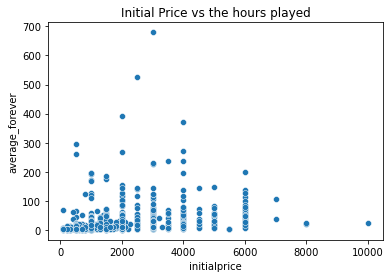

In [8]:
e.initial_price(train)

In [9]:
e.get_chi_initialprice(train)

chi^2 = 40257.6298
p     = 0.1719


## Does the Developer matter?

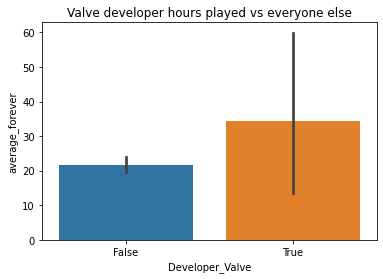

In [10]:
e.developer_visual(train)

In [11]:
e.get_chi_valve(train)

chi^2 = 905.6678
p     = 0.7101


## Does the Publisher matter?

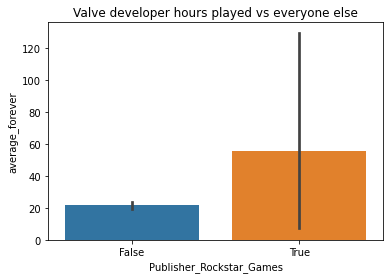

In [12]:
e.publisher_visual(train)

In [13]:
e.get_chi_publisher(train)

chi^2 = 1060.5502
p     = 0.0018


## Does the discount matter?

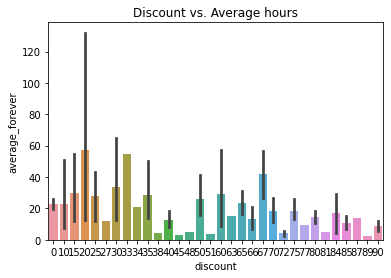

In [14]:
e.discount_visual(train)

In [15]:
e.get_chi_discount(train)

chi^2 = 28963.2900
p     = 0.2888


# Does the genre determine hours?

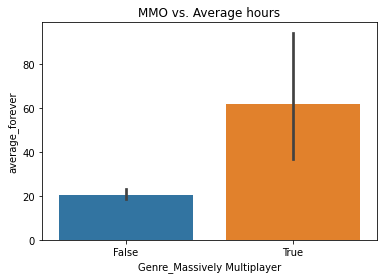

In [14]:
e.MMO_visual(train)

## Are Free to Play games played more or less than paid games?

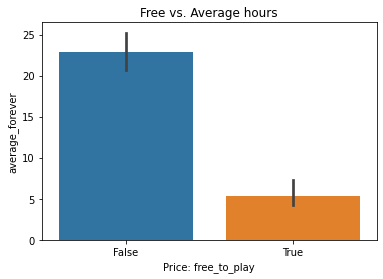

In [15]:
e.free_to_play(train)

#### This descrepency could be due to lack of price barrier meaning it could be acquired and discarded with no consequence

# Exploration Summary
* The Developer matters to hours of gameplay
* The discount doesn't really matter
* Initial Price was found to be a driver of hours of gameplay

## Features moving forward
* Developer
* Initial Price

# Modeling
* We will use accuracy as the evalutaion metric
* 80% will be the baseline
* Evaluation of models developed using four different model types and various hyperparameter configurations
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data

In [ ]:
# Prep data for modeling

## Decision Tree

In [9]:
# get Decision Tree results

## Random Forest

In [10]:
# get Random Forest results

## Logistic Regression

In [11]:
# get Logistic Regression results

## KNN

In [12]:
# get KNN results

## XG Boost

In [ ]:
# get XG Boost results

## Gradient Boosting

In [ ]:
# get Gradient Boosting results

## Comparing Models
* 
* 
* 

# ...On Test

In [ ]:
# get test results for final model

## Modeling Summary
* 
* 
* 

# Conclusions

## Exploration

* 

## Modeling

* 

## Recomendations

* 

## Next Steps

* 